# Tabular Binary Model

Test ML models for tabular data - try models that are binary (no findings = zero, any finding = 1) vs multi label models
If the binary model works well, then save model weights and hidden embeddings and try adding it to the fusion models

### Classifers to try:

1. Logistic Regression
2. SVM
3. KNN
4. XGBoost

In [1]:
%run processing_data.ipynb

Loading data files... C:/Users/Carolyn/Documents/MIDS/210 Capstone/fusion_data\test_set__chexpert__4_findings__single_label__unbalanced.json test
Loading data files... C:/Users/Carolyn/Documents/MIDS/210 Capstone/fusion_data\train_set__chexpert__4_findings__single_label__balanced.json train
Loading data files... C:/Users/Carolyn/Documents/MIDS/210 Capstone/fusion_data\validation_set__chexpert__4_findings__single_label__unbalanced.json validate
Total Cols
 Index(['patient_id', 'visit_id', 'study_id', 'temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'positive_label_total', 'finding_names', 'radiology_note',
       'discharge_note', 'chief_complaint',
       'major_surgical_or_invasive_procedure', 'history_of_present_illness',
       'past_medical_history', 'family_history', 'atelectasis', 'cardiomegaly',
       'lung_opacity', 'pleural_effusion', 'dataset_type'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16877 en

In [68]:
import json

import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.optim as optim
from torchinfo import summary
from torch.nn import functional as F
import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, hamming_loss, multilabel_confusion_matrix

from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

import xgboost as xgb

import seaborn as sn
import matplotlib.pyplot as plt

In [7]:
tabular_train_df.head()

,patient_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,finding_names
0,11388716,98.8,106.0,22.0,96.0,93.0,67.0,0,2.0,atelectasis
1,11539363,99.1,80.0,16.0,97.0,162.0,67.0,0,3.0,atelectasis
2,10833304,97.0,98.0,14.0,100.0,159.0,88.0,2,2.0,atelectasis
3,19849119,98.6,92.0,20.0,98.0,127.0,70.0,0,2.0,atelectasis
4,11749991,100.6,110.0,16.0,97.0,166.0,100.0,8,2.0,atelectasis


In [8]:
#create binary dataset
tabular_train_df_binary = tabular_train_df
tabular_train_df_binary['findings'] = 0
tabular_train_df_binary.loc[tabular_train_df_binary['finding_names'] != 'no_finding','findings'] = 1

#validation
tabular_val_df_binary = tabular_val_df
tabular_val_df_binary['findings'] = 0
tabular_val_df_binary.loc[tabular_val_df_binary['finding_names'] != 'no_finding','findings'] = 1


#test
tabular_test_df_binary = tabular_test_df
tabular_test_df_binary['findings'] = 0
tabular_test_df_binary.loc[tabular_test_df_binary['finding_names'] != 'no_finding','findings'] = 1


tabular_train_df_binary.head()

C:\Users\Carolyn\AppData\Local\Temp\ipykernel_22388\320278615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabular_train_df_binary['findings'] = 0
C:\Users\Carolyn\AppData\Local\Temp\ipykernel_22388\320278615.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabular_val_df_binary['findings'] = 0
C:\Users\Carolyn\AppData\Local\Temp\ipykernel_22388\320278615.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,patient_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,finding_names,findings
0,11388716,98.8,106.0,22.0,96.0,93.0,67.0,0,2.0,atelectasis,1
1,11539363,99.1,80.0,16.0,97.0,162.0,67.0,0,3.0,atelectasis,1
2,10833304,97.0,98.0,14.0,100.0,159.0,88.0,2,2.0,atelectasis,1
3,19849119,98.6,92.0,20.0,98.0,127.0,70.0,0,2.0,atelectasis,1
4,11749991,100.6,110.0,16.0,97.0,166.0,100.0,8,2.0,atelectasis,1


In [10]:
tabular_train_df_binary.findings.unique()

array([1, 0], dtype=int64)

In [11]:
#loading datasets
train_x = tabular_train_df_binary[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']]
val_x = tabular_val_df_binary[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']]
test_x = tabular_test_df_binary[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']]

train_y = tabular_train_df_binary['findings']
val_y = tabular_val_df_binary['findings']
test_y = tabular_test_df_binary['findings']

print("TRAIN: shape of x: {}\nshape of y: {}".format(train_x.shape,train_y.shape))
print("VAL: shape of x: {}\nshape of y: {}".format(val_x.shape,val_y.shape))
print("TEST: shape of x: {}\nshape of y: {}".format(test_x.shape,test_y.shape))

TRAIN: shape of x: (2086, 8)
shape of y: (2086,)
VAL: shape of x: (1924, 8)
shape of y: (1924,)
TEST: shape of x: (1920, 8)
shape of y: (1920,)


In [12]:
#feature scaling
sc = StandardScaler()

train_x = sc.fit_transform(train_x)
val_x = sc.fit_transform(val_x)
test_x = sc.fit_transform(test_x)

In [29]:
#adjust parameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 1000

In [30]:
#defining dataset class
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
      
trainset = dataset(train_x,train_y)

#DataLoader
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=False)

In [31]:
#without Dataloader
X_train = torch.from_numpy(train_x).float()
X_val = torch.from_numpy(val_x).float()

y_train = torch.from_numpy(train_y.to_numpy()).float().reshape(len(train_y), 1)
y_val = torch.from_numpy(val_y.to_numpy()).float().reshape(len(val_y), 1)

## Logistic Regression

In [32]:
# build custom module for logistic regression
class LogisticRegression(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.layer0 = nn.Linear(in_features=num_features, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer0(x)
        x = self.sigmoid(x)
        return x

In [33]:
# Model , Optimizer, Loss
model = LogisticRegression(num_features=train_x.shape[1])
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.BCELoss()

In [34]:
summary(model, input_size=train_x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
LogisticRegression                       [2086, 1]                 --
├─Linear: 1-1                            [2086, 1]                 9
├─Sigmoid: 1-2                           [2086, 1]                 --
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.07
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.08

In [35]:
def calculate_accuracy(preds, actuals):
    
    with torch.no_grad():
        rounded_preds = torch.round(preds)
        num_correct = torch.sum(rounded_preds == actuals)
        accuracy = num_correct/len(preds)
        
    return accuracy

In [36]:
train_losses = []
test_losses  = []
train_accs = []
test_accs  = []

for epoch in range(EPOCHS):
    # Forward propagation (predicting train data) #a
    train_preds = model(X_train)
    train_loss  = loss_function(train_preds, y_train)
    
    # Predicting test data #b
    with torch.no_grad():
        test_preds = model(X_val)
        test_loss  = loss_function(test_preds, y_val)
        
    # Calculate accuracy #c
    train_acc = calculate_accuracy(train_preds, y_train)
    test_acc  = calculate_accuracy(test_preds, y_val)
    
    # Backward propagation #d
    optimizer.zero_grad()
    train_loss.backward()

    # Gradient descent step #e
    optimizer.step()
    
    # Store training history #f
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
    
    # Print training data #g
    if epoch%100==0:
        print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(test_acc.item(),2)}')

Epoch: 0 	| Train loss: 0.696 	| Test loss: 0.783 	| Train acc: 0.55 	| Test acc: 0.4
Epoch: 100 	| Train loss: 0.666 	| Test loss: 0.789 	| Train acc: 0.61 	| Test acc: 0.36
Epoch: 200 	| Train loss: 0.648 	| Test loss: 0.799 	| Train acc: 0.64 	| Test acc: 0.33
Epoch: 300 	| Train loss: 0.637 	| Test loss: 0.811 	| Train acc: 0.65 	| Test acc: 0.31
Epoch: 400 	| Train loss: 0.631 	| Test loss: 0.822 	| Train acc: 0.66 	| Test acc: 0.3
Epoch: 500 	| Train loss: 0.626 	| Test loss: 0.832 	| Train acc: 0.66 	| Test acc: 0.3
Epoch: 600 	| Train loss: 0.624 	| Test loss: 0.841 	| Train acc: 0.66 	| Test acc: 0.29
Epoch: 700 	| Train loss: 0.622 	| Test loss: 0.848 	| Train acc: 0.66 	| Test acc: 0.29
Epoch: 800 	| Train loss: 0.62 	| Test loss: 0.854 	| Train acc: 0.66 	| Test acc: 0.29
Epoch: 900 	| Train loss: 0.62 	| Test loss: 0.859 	| Train acc: 0.66 	| Test acc: 0.29


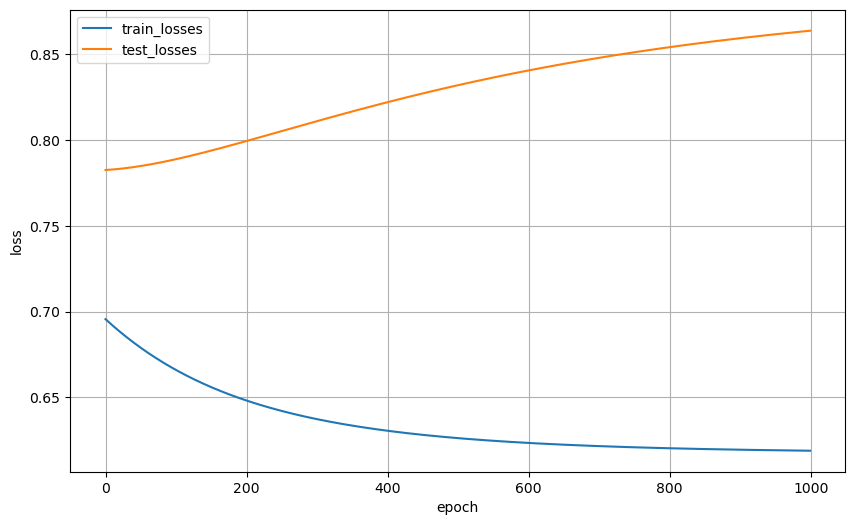

In [37]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses', 'test_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

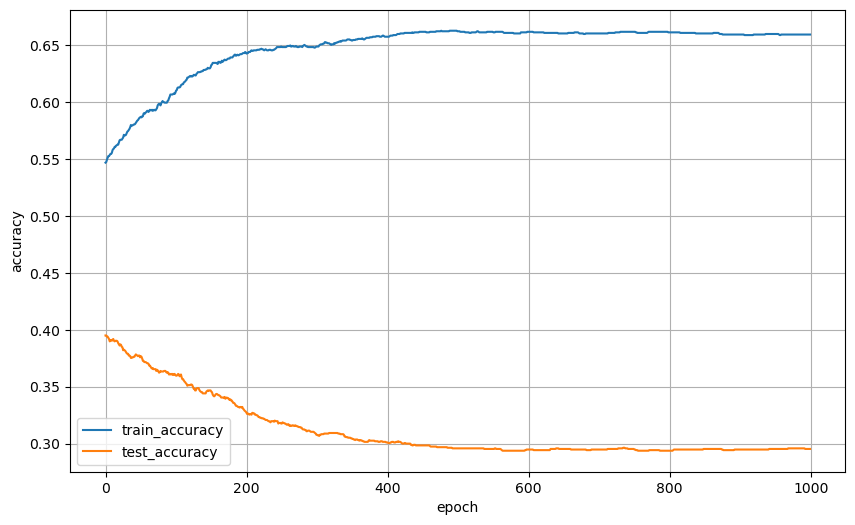

In [38]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accuracy', 'test_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

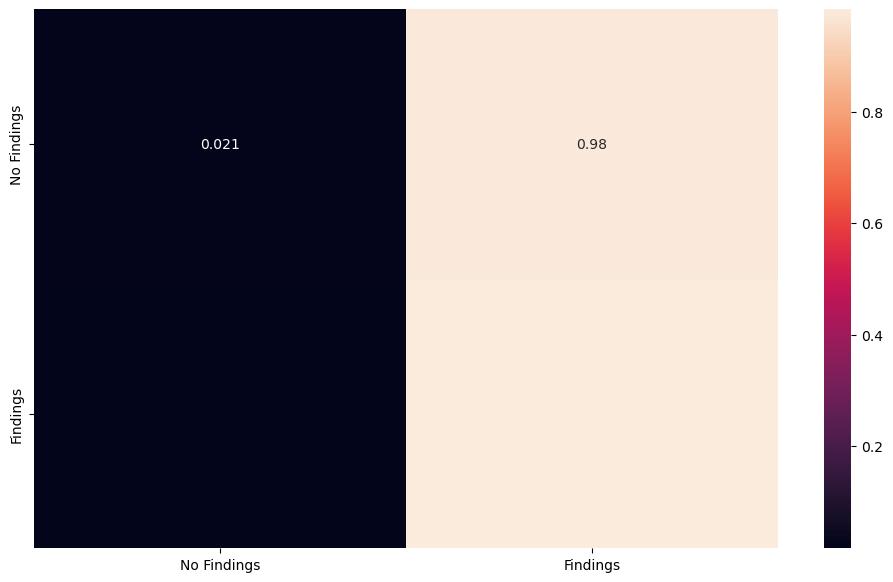

In [43]:
# constant for classes
classes = ('No Findings', 'Findings')

# Build confusion matrix
cf_matrix = confusion_matrix(y_val, test_preds.round())
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## SVM

In [54]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_val)

In [55]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_val, y_pred))

Accuracy: 0.28482328482328484


In [57]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']}  
  
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train.ravel()) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.663 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.664 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.664 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.662 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.662 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.663 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.664 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.664 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.662 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.662 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.663 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [58]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)


In [59]:
grid_predictions = grid.predict(X_val) 
  
# print classification report 
print(classification_report(y_val, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1376
         1.0       0.28      1.00      0.44       548

    accuracy                           0.28      1924
   macro avg       0.14      0.50      0.22      1924
weighted avg       0.08      0.28      0.13      1924



C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

## KNN

In [62]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [63]:
y_pred = knn.predict(X_val)

In [64]:
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4573804573804574


In [70]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train.ravel(), cv=5)
    scores.append(np.mean(score))

C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Accuracy Score')

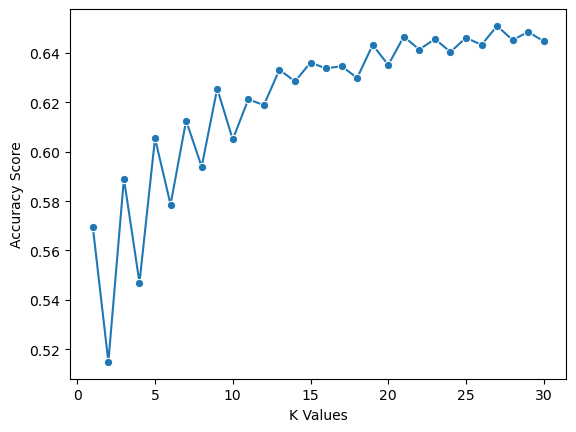

In [72]:
sn.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [94]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

C:\Users\Carolyn\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=2)

In [95]:
y_pred = knn.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5644490644490644


In [73]:
# XGBoost

In [76]:
# XGBoost (different learning rate)
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = [] 
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(X_train, y_train.ravel())
    train_XG.append(xgb_classifier.score(X_train, y_train.ravel()))
    test_XG.append(xgb_classifier.score(X_val, y_val.ravel()))

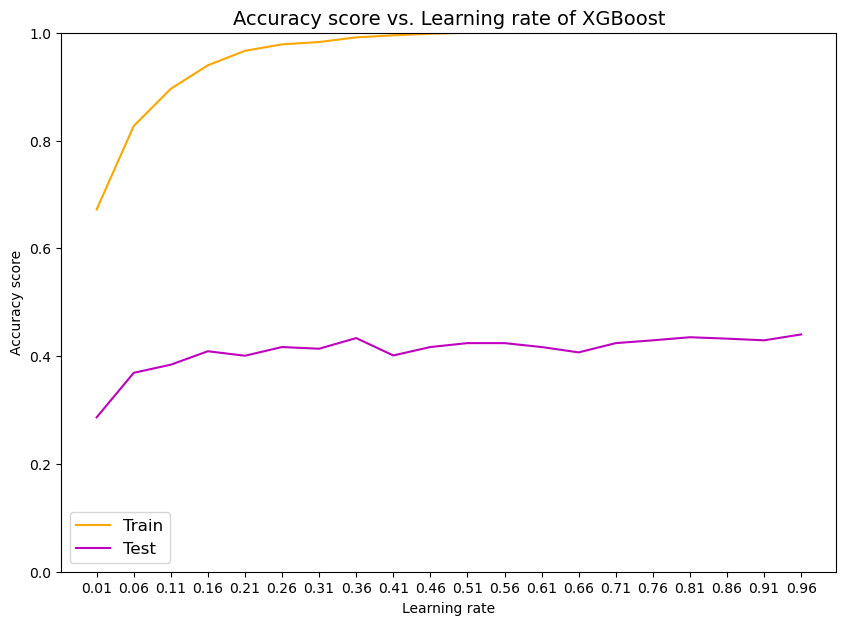

In [79]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

In [78]:
test_XG

[0.28638253638253636,
 0.369022869022869,
 0.3840956340956341,
 0.409043659043659,
 0.4007276507276507,
 0.41683991683991684,
 0.41372141372141374,
 0.43347193347193347,
 0.40124740124740127,
 0.41683991683991684,
 0.42411642411642414,
 0.42411642411642414,
 0.41683991683991684,
 0.40696465696465695,
 0.42411642411642414,
 0.4293139293139293,
 0.43503118503118504,
 0.43243243243243246,
 0.4293139293139293,
 0.4402286902286902]